# Algorithms exercise: 

**Problem:**
Everyone loves alphabet soup.  And of course you want to know if you can
construct a message from the letters found in your bowl.
Write a function that takes as input two strings: first, the message you
want to write; and second, all the letters found in your bowl of
alphabet soup.  Assume the letters are ordered randomly, just as in your
bowl.  Also assume you may have a very large bowl of soup containing
many letters - though there is no guarantee that each letter occurs a
similar number of times - indeed some letters might be missing entirely.
The function should determine if you can write your message with the
letters found in your bowl of soup.  The function should return true or
false accordingly.

**Short version:**
Determine wether a given random string can be constructed from characters present in another random string.

---

There are three parameters to this problem, the first is the size of the first string N (the word), the second is the size of the second string M (the bowl) and the third is the size K of the alphabet used in both strings.

The naive approach (**NaiveSearcher**) is to execute a linear search on the bowl for each letter in the word. Each search for a given letter will be slower and slower since the letters already found in the bowl can't be used again. We can simplify the problem if we look at the case with an alphabet of size K=1. Then if the word is of size N=5, we would need to make 1 + 2 + 3 + 4 + 5 tests, for arbitrarily large N this is calculated with the following formula: n(n+1)/2, which is bounded by n^2 making the time complexity of the calculation O(N^2). For bigger alphabets the complexity should be similar with an added constant derived from K.

Another approach (**RandomSearcher**) is starting each search at a random position inside de bowl. If the bowl is big compared to the word and the letters inside it are evenly distributed then searching for a given letter should be done on average in K/2 tests. This should give the algorithm a time complexity of O(K/2*N). If the bowl is similar in size to the word then the time spent to process a word should start growing like O(N^2) again.

### Preprocessing

We can also preprocess the entire bowl at the beginning, counting the number of times each letter appears and then using this information to check if we can build the word or not (**CounterSearcher**). This is implemented with the Counter classes and it is done in O(M) time. After the preprocessing step the search for the word has time complexity O(N). The cost of both operations, preprocessing and search is O(M + N). 

### Paralellization

If the bowl is very big the counting operation looks slow, however the problem of counting is perfectly paralell and we should gain a big speedup by partitioning the bowl and using as many threads as possible to make the counting. For this I have implemented the **CounterSearcherParalell** and **CounterSearcherGPU** classes. **CounterSearcherParalell** executes in half the time of the single threaded version when using a CPU with two cores. **CounterSearcherGPU** uses the cupy library which is an implementation of numpy that runs on the GPU by using NVIDIA CUDA. Using a NVIDIA Tesla K80 card it runs as fast as 70x faster than the Paralell class, moreover, as the bowl gets bigger it is faster and faster because the data can be partitioned even more, that means more CUDA cores or threads are used the bigger the bowl is.

### Online algorithm

The final approach implemented in the **CounterSearcherOnline** class works in a similar way to the naive algorithm, but this time we count every letter as we iterate over the bowl. When we find one letter the next letter is looked up in the counts first, if it isn't found there we start iterating in the bowl again but starting from the last position where we found a letter. The complexity of this algorithm is O(yN) where y is an added constant factor related to the size of the alphabet K.

### Conclusion

The algorithm to use depends on the size of the bowl and on wether we can preprocess the whole bowl at once. If the bowl is of reasonable size and we have all of it beforehand then the faster approach seems to be the GPU preprocessing. If we only have one thread available the best approach should be the online algorithm. If we only have part of the bowl and the rest is being streamed from somewhere else we could use the online algorithm or we could preprocess the bowl in chunks as they become available. The GPU preprocessing seems to win always if available, in theory the preprocessing + search approach is done in O(M+N) while the online approach is done in O(yN). In practice if we take into account the fact that the O(M) preprocessing part is split among a lot of CUDA cores and that the online algorithm has an added constant factor 'y' then the online algorithm becomes slower.

In [2]:
import random
import string
import timeit
import os
import numpy as np

import cupy as cp # CUDA based implementation of numpy.ndarray (GPU)
from cupy.statistics.histogram import bincount

from collections import Counter
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class Searcher:
    """ Base class for all the searchers """

    def __init__(self, bowl):
        self.bowl = bowl

    def preprocess(self):
        pass
    
    def search(self):
        pass

class NaiveSearcher(Searcher):
    """ 
    Naive algorithm, iterates over the letters in the bowl until finding 
    each letter in the message.
    The time complexity of this algorithm is of order O(n^2) 
    """

    def search(self, message):
        already_picked = []

        def findletter_naive(l):
            for idx,i in enumerate(self.bowl):
                if i == l and idx not in already_picked:
                    already_picked.append(idx)
                    return True
            else:
                return False

        return all(findletter_naive(i) for i in message)

class RandomSearcher(Searcher):
    """
    This is similar to the naive searcher but starting the search at random 
    places in the bowl, if the bowl is big compared to the message and the 
    letters are evenly distributed then the time complexity should be 
    of order O(n) because each letter will be found in a constant amount 
    of time that depends on the size of the alphabet.
    
    For bigger messages the performance should degrade to O(n^2)
    """
    
    def search(self, message):
        already_picked = {}

        def findletter_random(l):
            start = np.random.choice(len(self.bowl))
            for idx, i in enumerate(self.bowl[start: len(self.bowl)]):
                if i == l and idx+start not in already_picked:
                    already_picked[idx+start] = 1
                    return True
            for idx, i in enumerate(self.bowl[0: start]):
                if i == l and idx not in already_picked:
                    already_picked[idx] = 1
                    return True
            return False
        
        return all(findletter_random(i) for i in message)
    
class CounterSearcher(Searcher):
    """
    This algorithm starts by preprocessing the full bowl by counting how 
    many letters of each kind the bowl contains. The counts are saved into 
    a hashtable. This process is of complexity O(m). After the preprocessing 
    step each search is made in O(n) time since we have to access the hashtable 
    with the counts n times and each access to the hashtable is made in O(1) time.
    The very first search is then made in O(m + n) time.
    """
    
    def __init__(self, bowl):
        super(CounterSearcher, self).__init__(bowl)

    def preprocess(self):
        self.counts = Counter(self.bowl)
        
    def search(self, message):
        found = Counter()

        for letter in message:
            if letter in self.counts and self.counts[letter] > found[letter]: 
                found[letter] += 1
            else:
                return False

        return True

# This has to be declared as a global method otherwise there are some
# problems with the multiprocessing library
def countfn(x):
    return Counter(x)

class CounterSearcherParalell(CounterSearcher):
    """
    This is similar to the CounterSearcher class but the preprocessing 
    step is executed in paralell. Since the counting problem is perfectly 
    paralellizable we should get a linear speedup with the addition
    of processing cores. Two cores should count the letters in half the time than one.
    """
    
    def __init__(self, bowl, cores=cpu_count()):
        super(CounterSearcherParalell, self).__init__(bowl)
        print("Initialized process Pool with {} proccesses.".format(cores))
        self.pool = Pool(cores)
        self.cores = cores
        
    def preprocess(self):
        
        chunk_size = len(self.bowl) // self.cores

        def chunks(l, n):
            """Yield successive n-sized chunks from l.
            https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks"""
            for i in range(0, len(l), n):
                yield l[i:i + n]
        
        #map
        parts = self.pool.map(countfn, list(chunks(self.bowl, chunk_size)))
        self.counts = None
        
        #reduce
        for p in parts:
            if self.counts == None:
                self.counts = p
            else:
                self.counts += p

class CounterSearcherGPU(CounterSearcher):
    """ This is similar to the CounterSearcher class but the preprocessing 
    is executed in a GPU. Since the counting problem is perfectly 
    paralellizable this should be much faster.
    
    The calculation is done with the cupy library wich is an implementation 
    of the numpy.ndarray class that works in the GPU.
    """
    def preprocess(self):
        nums = np.fromstring(self.bowl, dtype=np.uint8)
        self.counts = bincount(cp.asarray(nums))
        self.counts = {chr(idx):int(val) for idx, val in enumerate(self.counts) if idx > 96 and idx < 123}        

class CounterSearcherOnline(Searcher):
    """
    This is an online version of the Counter algorithms. It works in the same 
    way except that it builds the counts incrementally. Experimentally its time 
    complexity looks like its of order O(kn) with k being some factor that depends 
    on the size of the alphabet.If the alphabet is big the probability of finding 
    any given letter is smaller so we will spend a little more time searching in 
    the bowl instead of in the Counter.
,    """
    
    def search(self, message):
        
        counts = Counter()
        last_idx = 0
        found = 0
        
        for idx_message, i in enumerate(message):
            if i in counts and counts[i] > 0:
                found += 1
                counts[i] -= 1
                continue
            else:
                for idx_bowl, j in enumerate(self.bowl[last_idx:]):
                    if i == j:
                        found += 1
                        break
                    else:
                        counts[j] += 1
        
        return found == len(message)

In [4]:
def get_str(n):
    """ fast generation of random string """
    """ https://stackoverflow.com/questions/16308989/fastest-method-to-generate-big-random-string-with-lower-latin-letters """
    min_lc = ord(b'a')
    len_lc = 26
    ba = bytearray(os.urandom(n))
    for i, b in enumerate(ba):
        ba[i] = min_lc + b % len_lc # convert 0..255 to 97..122
    return ba.decode("utf-8")

def benchmark_bowls(searcher, range_, message_size=500, printfreq=100):
    """
    Executes a given searcher with increasing message sizes
    """
        
    message = get_str(500)
    
    times = []
    last = 0
    
    for i in range_:
        bowl = get_str(i)
        
        searcher.bowl = bowl
        start_time = timeit.default_timer()
        searcher.preprocess()
        elapsed = timeit.default_timer() - start_time
    
        searcher.search(message)
        # print logging message once every printfreq iterations
        if i // printfreq > last:
            last = i // printfreq
            print("{}(M={}) preprocessed bowl in {:f} seconds".format(
            searcher.__class__.__name__, len(bowl), elapsed))
    
        times.append(elapsed)
        
    return times
        
def benchmark_messages(searcher, bowl, range_, printfreq=100):
    """
    Executes a given searcher with increasing message sizes
    """
    
    times = []
    last = 0
    
    searcher.preprocess()
    
    for i in range_:
        
        message = get_str(i)
        
        start_time = timeit.default_timer()
        result = searcher.search(message)
        elapsed = timeit.default_timer() - start_time
        
        # print logging message once every printfreq iterations
        if i // printfreq > last:
            last = i // printfreq
            print("{}(N={}, M={}) returned {} in {:f} seconds".format(
            searcher.__class__.__name__, len(message), len(bowl), result, elapsed))
    
        times.append(elapsed)
        
    return times

In [5]:
bowl = get_str(1000000)

naive = NaiveSearcher(bowl)    
naive_times = benchmark_messages(naive, bowl, range(1,1000,10))

random = RandomSearcher(bowl)
random_times = benchmark_messages(random, bowl, range(1,1000,10))

counter = CounterSearcher(bowl)
counter_times = benchmark_messages(counter, bowl, range(1,1000,10))

counter_paralell = CounterSearcherParalell(bowl)
counter_paralell_times = benchmark_messages(counter_paralell, bowl, range(1,1000,10))

counter_gpu = CounterSearcherGPU(bowl)
counter_gpu_times = benchmark_messages(counter_gpu, bowl, range(1,1000,10))

counter_online = CounterSearcherOnline(bowl)
counter_online_times = benchmark_messages(counter_online, bowl, range(1, 1000, 10))

NaiveSearcher(N=101, M=1000000) returned True in 0.000886 seconds
NaiveSearcher(N=201, M=1000000) returned True in 0.003799 seconds
NaiveSearcher(N=301, M=1000000) returned True in 0.008700 seconds
NaiveSearcher(N=401, M=1000000) returned True in 0.017628 seconds
NaiveSearcher(N=501, M=1000000) returned True in 0.032347 seconds
NaiveSearcher(N=601, M=1000000) returned True in 0.048070 seconds
NaiveSearcher(N=701, M=1000000) returned True in 0.072229 seconds
NaiveSearcher(N=801, M=1000000) returned True in 0.100858 seconds
NaiveSearcher(N=901, M=1000000) returned True in 0.136770 seconds
RandomSearcher(N=101, M=1000000) returned True in 0.004900 seconds
RandomSearcher(N=201, M=1000000) returned True in 0.010578 seconds
RandomSearcher(N=301, M=1000000) returned True in 0.015758 seconds
RandomSearcher(N=401, M=1000000) returned True in 0.020690 seconds
RandomSearcher(N=501, M=1000000) returned True in 0.025756 seconds
RandomSearcher(N=601, M=1000000) returned True in 0.031453 seconds
Rand

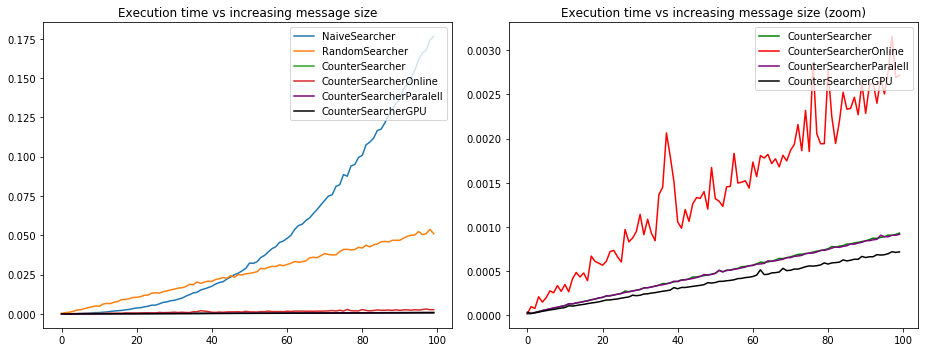

In [6]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.plot(naive_times, label="NaiveSearcher")
plt.plot(random_times, label="RandomSearcher")
plt.plot(counter_times, label="CounterSearcher")
plt.plot(counter_online_times, label="CounterSearcherOnline")
plt.plot(counter_paralell_times, label="CounterSearcherParalell", color='purple')
plt.plot(counter_gpu_times, label="CounterSearcherGPU", color='black')
plt.title('Execution time vs increasing message size')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(counter_times, label="CounterSearcher", color='green')
plt.plot(counter_online_times, label="CounterSearcherOnline", color='red')
plt.plot(counter_paralell_times, label="CounterSearcherParalell", color='purple')
plt.plot(counter_gpu_times, label="CounterSearcherGPU", color='black')
plt.legend(loc='upper right')
plt.title('Execution time vs increasing message size (zoom)')
plt.tight_layout()

In [7]:
dummy_bowl = get_str(100000)
counter_times = benchmark_bowls(CounterSearcher(dummy_bowl), 
                                range(10000,1000000,10000), 500, 100000)
counter_paralell_times = benchmark_bowls(CounterSearcherParalell(dummy_bowl), 
                                         range(10000,1000000,10000), 500, 100000)
counter_gpu_times = benchmark_bowls(CounterSearcherGPU(dummy_bowl), 
                                    range(10000,1000000,10000), 500, 100000)

CounterSearcher(M=100000) preprocessed bowl in 0.006710 seconds
CounterSearcher(M=200000) preprocessed bowl in 0.013525 seconds
CounterSearcher(M=300000) preprocessed bowl in 0.020330 seconds
CounterSearcher(M=400000) preprocessed bowl in 0.026962 seconds
CounterSearcher(M=500000) preprocessed bowl in 0.033627 seconds
CounterSearcher(M=600000) preprocessed bowl in 0.039949 seconds
CounterSearcher(M=700000) preprocessed bowl in 0.046413 seconds
CounterSearcher(M=800000) preprocessed bowl in 0.053306 seconds
CounterSearcher(M=900000) preprocessed bowl in 0.060771 seconds
Initialized process Pool with 4 proccesses.
CounterSearcherParalell(M=100000) preprocessed bowl in 0.006452 seconds
CounterSearcherParalell(M=200000) preprocessed bowl in 0.008584 seconds
CounterSearcherParalell(M=300000) preprocessed bowl in 0.012815 seconds
CounterSearcherParalell(M=400000) preprocessed bowl in 0.017014 seconds
CounterSearcherParalell(M=500000) preprocessed bowl in 0.020876 seconds
CounterSearcherParal

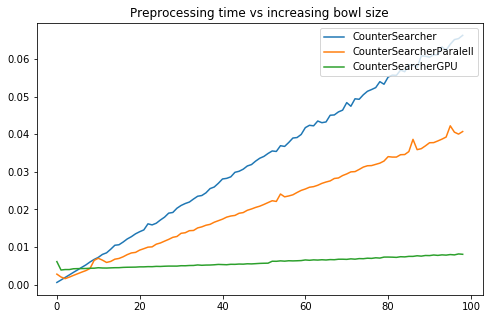

In [8]:
# All the countings are completed in linear time but the GPU based is much faster

plt.figure(figsize=(8, 5))
plt.plot(counter_times, label="CounterSearcher")
plt.plot(counter_paralell_times, label="CounterSearcherParalell")
plt.plot(counter_gpu_times, label="CounterSearcherGPU")
plt.title('Preprocessing time vs increasing bowl size')
plt.legend(loc='upper right')

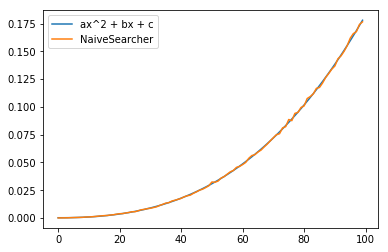

In [16]:
# A polynomial of type y = aX^2 +bx + c fits perfectly the benchmark of the RandomSearcher algorithm

poly = np.polyfit([x for x, _ in enumerate(naive_times)], naive_times, 3)
plt.plot([np.polyval(poly, x) for x in range(100)], label='ax^2 + bx + c')
plt.plot(naive_times, label='NaiveSearcher')
plt.legend()

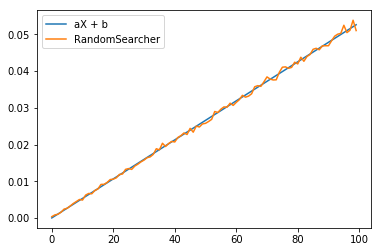

In [19]:
# A polynomial of type y = aX + b fits perfectly the benchmark of the RandomSearcher algorithm

poly = np.polyfit([x for x, _ in enumerate(random_times)], random_times, 1)
plt.plot([np.polyval(poly, x) for x in range(100)], label='aX + b')
plt.plot(random_times, label = 'RandomSearcher')
plt.legend()